In [65]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import  Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import RMSprop

In [14]:
# Import the data from your Drive folder

images_train = np.load('data/images_train.npy') / 255.
images_valid = np.load('data/images_valid.npy') / 255.
images_test = np.load('data/images_test.npy') / 255.

labels_train = np.load('data/labels_train.npy')
labels_valid = np.load('data/labels_valid.npy')
labels_test = np.load('data/labels_test.npy')

In [15]:
print("{} training data examples".format(images_train.shape[0]))
print("{} validation data examples".format(images_valid.shape[0]))
print("{} test data examples".format(images_test.shape[0]))

600 training data examples
300 validation data examples
300 test data examples


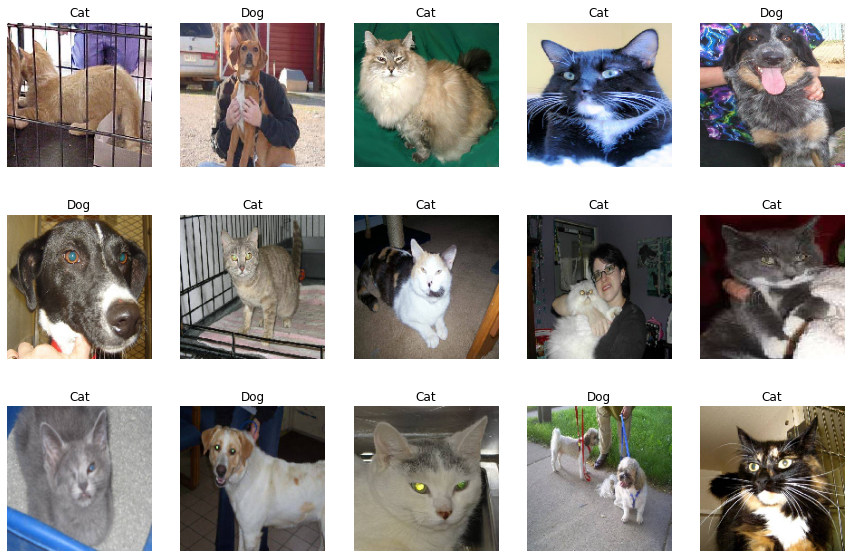

In [16]:
# Display a few images and labels
class_names = np.array(['Dog', 'Cat'])

plt.figure(figsize=(15,10))
inx = np.random.choice(images_train.shape[0], 15, replace=False)
for n, i in enumerate(inx):
    ax = plt.subplot(3,5,n+1)
    plt.imshow(images_train[i])
    plt.title(class_names[labels_train[i]])
    plt.axis('off')

In [68]:
# Let us define a baseline model. We will compare the performance of this model
# against the performance of a transfer learning model
def get_benchmark_model(input_shape):
    """
    This function should build and compile a CNN model according to the above specification,
    using the functional API. The function takes input_shape as an argument, which should be
    used to specify the shape in the Input layer.
    Your function should return the model.
    """

  
    inputs = Input(shape=input_shape)
    h = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    h = Conv2D(32, (3, 3), activation="relu", padding="same")(h)
    h = MaxPool2D((2, 2))(h)
    h = Conv2D(64, (3, 3), activation="relu", padding="same")(h)
    h = Conv2D(64, (3, 3), activation="relu", padding="same")(h)
    h = MaxPool2D((2, 2))(h)
    h = Conv2D(128, (3, 3), activation="relu", padding="same")(h)
    h = Conv2D(128, (3, 3), activation="relu", padding="same")(h)
    h = MaxPool2D((2, 2))(h)
    h = Flatten()(h)
    h = Dense(128, activation="relu")(h)
    outputs = Dense(1, activation="sigmoid")(h)

    model = Model(inputs=inputs, outputs=outputs)
    
    # Compile the model
    opt = tf.keras.optimizers.RMSprop(0.001)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model
   

In [69]:
# Build and compile the model
benchmark_model = get_benchmark_model(images_train[0].shape)
benchmark_model.summary(). # Print the summary of the model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 160, 160, 32)      896       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 160, 160, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 80, 80, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 80, 80, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 80, 80, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 40, 40, 64)        0   

In [70]:
# Define an earlystopping callback
earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)

# Train the baseline model
history_benchmark = benchmark_model.fit(images_train, labels_train, epochs=20, batch_size=32,
                                        validation_data=(images_valid, labels_valid), 
                                        callbacks=[earlystopping])

Epoch 1/20
19/19 [==============================] - 2s 86ms/step - loss: 1.9377 - accuracy: 0.4868 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
19/19 [==============================] - 1s 75ms/step - loss: 0.6961 - accuracy: 0.5159 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/20
19/19 [==============================] - 1s 74ms/step - loss: 0.6973 - accuracy: 0.5202 - val_loss: 0.7241 - val_accuracy: 0.5000
Epoch 4/20
19/19 [==============================] - 1s 75ms/step - loss: 0.7071 - accuracy: 0.5377 - val_loss: 0.6824 - val_accuracy: 0.6167
Epoch 5/20
19/19 [==============================] - 2s 83ms/step - loss: 0.7030 - accuracy: 0.5471 - val_loss: 0.6910 - val_accuracy: 0.5267
Epoch 6/20
19/19 [==============================] - 1s 75ms/step - loss: 0.6829 - accuracy: 0.5805 - val_loss: 0.6884 - val_accuracy: 0.5600


#### Plot the learning curves

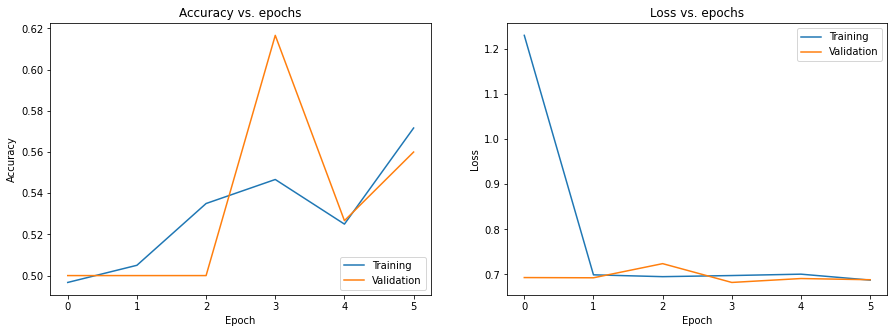

In [71]:
# Plot accuracy vs epoch and loss vs epoch
plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_benchmark.history['accuracy'])
    plt.plot(history_benchmark.history['val_accuracy'])
except KeyError:
    plt.plot(history_benchmark.history['acc'])
    plt.plot(history_benchmark.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_benchmark.history['loss'])
plt.plot(history_benchmark.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [72]:
# Evaluate the baseline model on the test set
benchmark_test_loss, benchmark_test_acc = benchmark_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(benchmark_test_loss))
print("Test accuracy: {}".format(benchmark_test_acc))

Test loss: 0.685908317565918
Test accuracy: 0.550000011920929


In [73]:
# Load a pretrained model
def load_pretrained_MobileNetV2(path):
    """
    This function takes a path as an argument, and uses it to 
    load the full MobileNetV2 pretrained model from the path.
    Your function should return the loaded model.
    """

    model = load_model(path)

    return model
    

In [74]:
# Load the pretrained model
base_model = load_pretrained_MobileNetV2('models/MobileNetV2.h5')
base_model.summary()  # Print the summary of the model

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [77]:
# Extracting all the layers of the pretrained model except for the last layer
def remove_head(pretrained_model):
    """
    This function takes a pretrained model as an argument.
    It should create and return a new model, using the input and output tensors as specified above. 
    Use the 'get_layer' method to access the correct layer of the pre-trained model.
    """

    new_model = Model(inputs=pretrained_model.input, 
                      outputs=pretrained_model.get_layer('global_average_pooling2d_6').output)
    
    return new_model
    
    

In [78]:
# Extracting relevant layers
feature_extractor = remove_head(base_model)
feature_extractor.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
____________________________________________________________________________________________

In [43]:
# Create a new model. Append the pretraind model with new layers
def add_new_classifier_head(feature_extractor_model):
    """
    This function takes the feature extractor model as an argument, and should create
    and return a new model according to the above specification.
    """

    model = Sequential([
                        feature_extractor_model,
                        Dense(32, activation="relu"),
                        Dropout(0.5),
                        Dense(1, activation="sigmoid")
                        
    ])

    return model
    
    

In [44]:
# Build the new model
new_model = add_new_classifier_head(feature_extractor)
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 2,264,897
Non-trainable params: 34,112
_________________________________________________________________


In [48]:
# Train the weights of the new layers
def freeze_pretrained_weights(model):
    """
    This function takes the model specified above as an argument, and should freeze the 
    weights of the pre-trained feature extractor (defined as the first layer of the model).
    It should also compile the model as described above.
    Your function should return the model with the specified frozen weights.
    """

    model.layers[0].trainable = False

    opt = tf.keras.optimizers.RMSprop(0.001)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model
    
    

In [49]:
frozen_new_model = freeze_pretrained_weights(new_model)
frozen_new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 1280)              2257984   
_________________________________________________________________
dense_6 (Dense)              (None, 32)                40992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 2,299,009
Trainable params: 41,025
Non-trainable params: 2,257,984
_________________________________________________________________


In [54]:
# Fit the new model
earlystopping = tf.keras.callbacks.EarlyStopping(patience=2)
history_frozen_new_model = frozen_new_model.fit(images_train, labels_train, epochs=10, batch_size=32,
                                                validation_data=(images_valid, labels_valid), 
                                                callbacks=[earlystopping])

Epoch 1/10
19/19 [==============================] - 4s 89ms/step - loss: 0.4451 - accuracy: 0.7859 - val_loss: 0.1676 - val_accuracy: 0.9300
Epoch 2/10
19/19 [==============================] - 1s 36ms/step - loss: 0.1407 - accuracy: 0.9480 - val_loss: 0.1080 - val_accuracy: 0.9600
Epoch 3/10
19/19 [==============================] - 1s 36ms/step - loss: 0.1513 - accuracy: 0.9438 - val_loss: 0.1056 - val_accuracy: 0.9633
Epoch 4/10
19/19 [==============================] - 1s 35ms/step - loss: 0.0999 - accuracy: 0.9742 - val_loss: 0.0997 - val_accuracy: 0.9667
Epoch 5/10
19/19 [==============================] - 1s 36ms/step - loss: 0.0547 - accuracy: 0.9781 - val_loss: 0.1065 - val_accuracy: 0.9633
Epoch 6/10
19/19 [==============================] - 1s 37ms/step - loss: 0.0692 - accuracy: 0.9774 - val_loss: 0.1060 - val_accuracy: 0.9600


#### Plot the learning curves

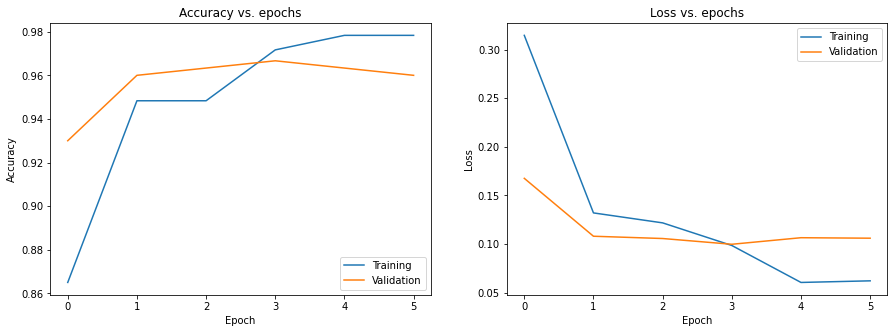

In [55]:
# Plot accuracy vs epoch and loss vs epoch

plt.figure(figsize=(15,5))
plt.subplot(121)
try:
    plt.plot(history_frozen_new_model.history['accuracy'])
    plt.plot(history_frozen_new_model.history['val_accuracy'])
except KeyError:
    plt.plot(history_frozen_new_model.history['acc'])
    plt.plot(history_frozen_new_model.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history_frozen_new_model.history['loss'])
plt.plot(history_frozen_new_model.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

In [56]:
# Evaluate the new model on the test set
new_model_test_loss, new_model_test_acc = frozen_new_model.evaluate(images_test, labels_test, verbose=0)
print("Test loss: {}".format(new_model_test_loss))
print("Test accuracy: {}".format(new_model_test_acc))

Test loss: 0.0822284072637558
Test accuracy: 0.9700000286102295


In [57]:
# Gather the baseline and new model metrics
benchmark_train_loss = history_benchmark.history['loss'][-1]
benchmark_valid_loss = history_benchmark.history['val_loss'][-1]

try:
    benchmark_train_acc = history_benchmark.history['acc'][-1]
    benchmark_valid_acc = history_benchmark.history['val_acc'][-1]
except KeyError:
    benchmark_train_acc = history_benchmark.history['accuracy'][-1]
    benchmark_valid_acc = history_benchmark.history['val_accuracy'][-1]

new_model_train_loss = history_frozen_new_model.history['loss'][-1]
new_model_valid_loss = history_frozen_new_model.history['val_loss'][-1]

try:
    new_model_train_acc = history_frozen_new_model.history['acc'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_acc'][-1]
except KeyError:
    new_model_train_acc = history_frozen_new_model.history['accuracy'][-1]
    new_model_valid_acc = history_frozen_new_model.history['val_accuracy'][-1]

In [58]:
# Compile the metrics into a pandas DataFrame and display the table
comparison_table = pd.DataFrame([['Training loss', benchmark_train_loss, new_model_train_loss],
                                ['Training accuracy', benchmark_train_acc, new_model_train_acc],
                                ['Validation loss', benchmark_valid_loss, new_model_valid_loss],
                                ['Validation accuracy', benchmark_valid_acc, new_model_valid_acc],
                                ['Test loss', benchmark_test_loss, new_model_test_loss],
                                ['Test accuracy', benchmark_test_acc, new_model_test_acc]],
                               columns=['Metric', 'Benchmark CNN', 'Transfer learning CNN'])
comparison_table.index=['']*6
comparison_table

,Metric,Benchmark CNN,Transfer learning CNN
,Training loss,0.580709,0.062106
,Training accuracy,0.685000,0.978333
,Validation loss,0.804435,0.105975
,Validation accuracy,0.536667,0.960000
,Test loss,0.770709,0.082228
,Test accuracy,0.573333,0.970000


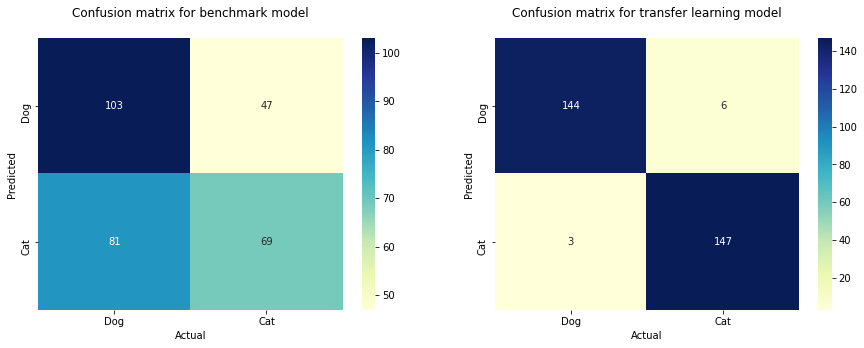

In [59]:
# Plot confusion matrices for baseline and transfer learning models
plt.figure(figsize=(15, 5))

preds = benchmark_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(121)
plt.title("Confusion matrix for benchmark model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

preds = frozen_new_model.predict(images_test)
preds = (preds >= 0.5).astype(np.int32)
cm = confusion_matrix(labels_test, preds)
df_cm = pd.DataFrame(cm, index=['Dog', 'Cat'], columns=['Dog', 'Cat'])
plt.subplot(122)
plt.title("Confusion matrix for transfer learning model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()